In [18]:
import pathlib
import re

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

import plotsauce.schemes as pltschemes

plt.style.use('pltstyle.mplstyle')

# Transformation in 2D

$\theta$: CCW+

Transformation matrix $[T]$

$$
m = cos(\theta),\; n = sin(\theta)
$$

$$
T = \begin{bmatrix}
m^2 & n^2 & 2mn \\
n^2 & m^2 & -2mn \\
-mn & mn & m^2 - n^2 \\
\end{bmatrix}
$$


Stress terms

$$
\begin{align*}
\sigma_{11} &= \sigma_{xx}m^2 + \sigma_{yy}n^2 + 2\sigma_{xy}mn \\
\sigma_{22} &= \sigma_{xx}n^2 + \sigma_{yy}m^2 - 2\sigma_{xy}mn \\
\sigma_{12} &= (\sigma_{yy} - \sigma_{xx})mn + \sigma_{xy}(m^2 - n^2)
\end{align*}
$$

Strain terms

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{xx}m^2 + \varepsilon_{yy}n^2 + 2\varepsilon_{xy}mn \\
\varepsilon_{22} &= \varepsilon_{xx}n^2 + \varepsilon_{yy}m^2 - 2\varepsilon_{xy}mn \\
\varepsilon_{12} &= (\varepsilon_{yy} - \varepsilon_{xx})mn + \varepsilon_{xy}(m^2 - n^2)
\end{align*}
$$

Local from global:

$$
\begin{align*}
[\varepsilon_{local}] &= [S_{local}][\sigma_{local}] \\
[T][\varepsilon_{global}] &= [S_{local}][T][\sigma_{global}]
\end{align*}
$$

# Full characterization of in-plane properties

## Assumptions

In the gage area, neglecting boundary effects, free strain in off-axis $(xx/xy)$ directions. Thus, off-axis stresses are $<< \sigma_{yy}$

- $\sigma_{xx} \approx 0$
- $\sigma_{xy} \approx 0$

Furthermore, measurement of strains in the pulling direction $\varepsilon_{yy}$ and transverse direction $\varepsilon_{xx}$ are expected to be known from the test data.

## $E_{11}$ and $\nu_{12}$

$\theta = 90^{\circ} \rightarrow m = 0,\; n = 1$

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{yy} \\
\varepsilon_{22} &= \varepsilon_{xx} \\
\sigma_{11} &= \sigma_{yy} \\
\sigma_{22} &= \sigma_{xx} = 0 \\
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{11} &= 1/E_{11}*\sigma_{11} - \nu_{12}/E_{11}*\sigma_{22} \\
\varepsilon_{yy} &= 1/E_{11}*\sigma_{yy} - \nu_{12}/E_{11}*\sigma_{xx} \\
\varepsilon_{yy} &= 1/E_{11}*\sigma_{yy} \\
\end{align*}
$$

$$
\therefore E_{11} = \frac{\sigma_{yy}}{\varepsilon_{yy}}
$$

$$
\begin{align*}
\nu_{12} &= -\varepsilon_{22}/\varepsilon_{11}
&= -\varepsilon_{yy}/\varepsilon_{xx}
\end{align*}
$$


$$
\therefore \nu_{12} = \frac{-\varepsilon_{yy}}{\varepsilon_{xx}}
$$

## $E_{22}$

$\theta = 0^{\circ} \rightarrow n = 0,\; m = 1$

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{xx} \\
\varepsilon_{22} &= \varepsilon_{yy} \\
\sigma_{11} &= \sigma_{xx} = 0 \\
\sigma_{22} &= \sigma_{yy} \\
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{22} &= -\nu_{12}/E_{11}*\sigma_{11} + 1/E_{22}*\sigma_{22} \\
\varepsilon_{yy} &= -\nu_{12}/E_{11}*\sigma_{xx} + 1/E_{22}*\sigma_{yy} \\
\varepsilon_{yy} &= 1/E_{22}*\sigma_{yy} \\
\end{align*}
$$

$$
\therefore E_{22} = \frac{\sigma_{yy}}{\varepsilon_{yy}}
$$

## $G_{12}$

$\theta = 45^{\circ} \rightarrow m = n = \frac{\sqrt{2}}{2}$

$$
\begin{align*}
\varepsilon_{12} &= (\varepsilon_{yy} - \varepsilon_{xx})mn = \frac{1}{2}(\varepsilon_{yy} - \varepsilon_{xx}) \\
\sigma_{12} &= (\sigma_{yy} - \sigma_{xx})mn = \frac{1}{2}\sigma_{yy}
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{12} &= \frac{1}{G_{12}}\sigma_{12} \\
\frac{1}{2}(\varepsilon_{yy} - \varepsilon_{xx}) &= \frac{1}{G_{12}}\frac{1}{2}\sigma{yy} \\
\end{align*}
$$

$$
\therefore G_{12} = \frac{\varepsilon_{yy}}{\varepsilon_{yy} - \varepsilon_{xx}}
$$


$$
m = cos(\theta),\; n = sin(\theta)
$$

$$
\theta = 0
$$

$$
\begin{align*}
\sigma_{11} &= \sigma_{xx}cos^{2}(\theta) + \sigma_{yy}sin^{2}(\theta) + 2\sigma_{xy}sin(\theta)cos(\theta) = \sigma_{xx} \\
\sigma_{22} &= \sigma_{xx}sin^{2}(\theta) + \sigma_{yy}cos^{2}(\theta) - 2\sigma_{xy}sin(\theta)cos(\theta) = \sigma_{yy} \\
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{22} &= \varepsilon_{xx}sin^{2}(\theta) + \varepsilon_{yy}cos^{2}(\theta) - 2\varepsilon_{xy}sin(\theta)cos(\theta) = \varepsilon_{yy} \\
\end{align*}
$$

$$
\varepsilon_{yy} = 1/E_{11}(\sigma_{xx}) - \nu_{12}/E_{11}(\sigma_{yy})
$$

$$
\therefore \nu_{12} = E_{11}\frac{\varepsilon_{yy}}{\sigma_{yy}}
$$


## $G_{12}$

Unknowns:

$G_{12}, \sigma_{xx}, \sigma_{xy}$

### $\theta = 30$

$$
\sin(30) = 1/2 \\
\cos(30) = \sqrt(3)/2
$$

$$
\begin{align*}
\varepsilon_{12} = \frac{\sqrt(3)}{4}\varepsilon_{yy} &= \frac{1}{2G_{12}}((\sigma_{yy} - \sigma_{xx})\frac{\sqrt(3)}{4} + \sigma_{xy}(\frac{3}{4} - \frac{1}{4})) \\
\frac{\sqrt(3)\delta}{40} &= \frac{1}{2G_{12}}(\frac{\sqrt(3)F}{8t} - \frac{\sqrt(3)\sigma_{xx}}{4} + \frac{\sigma_{xy}}{2}) \\
\frac{\sqrt(3)\delta G_{12}}{20} &= \frac{\sqrt(3)F}{8t} - \frac{\sqrt(3)\sigma_{xx}}{4} + \frac{\sigma_{xy}}{2} \\
\end{align*}
$$

$$
\therefore \frac{\sqrt(3)\sigma_{xx}}{4} + \frac{\sqrt(3)G_{12}\delta}{20} - \frac{\sigma_{xy}}{2} = \frac{\sqrt(3)F}{8t}
$$

### $\theta = 45$

$$
\sin(30) = \sqrt(2)/2 \\
\cos(30) = \sqrt(2)/2
$$

$$
\begin{align*}
\varepsilon_{12} = \frac{1}{2}\varepsilon_{yy} &= \frac{1}{2G_{12}}((\sigma_{yy} - \sigma_{xx})\frac{1}{2}) \\
\frac{\delta}{20} &= \frac{1}{2G_{12}}(\frac{F}{4t} - \frac{\sigma_{xx}}{2}) \\
\frac{G_{12}\delta}{10} &= (\frac{F}{4t} - \frac{\sigma_{xx}}{2})
\end{align*}
$$

$$
\therefore \frac{\sigma_{xx}}{2} + \frac{G_{12}\delta}{10} = \frac{F}{4t}
$$

### $\theta = 60$

$$
\sin(30) = \sqrt(3)/2 \\
\cos(30) = 1/2
$$

$$
\begin{align*}
\varepsilon_{12} = \frac{\sqrt(3)}{4}\varepsilon_{yy} &= \frac{1}{2G_{12}}((\sigma_{yy} - \sigma_{xx})\frac{\sqrt(3)}{4} + \sigma_{xy}(\frac{1}{4} - \frac{3}{4})) \\
\frac{\sqrt(3)\delta}{40} &= \frac{1}{2G_{12}}(\frac{\sqrt(3)F}{8t} - \frac{\sqrt(3)\sigma_{xx}}{4} - \frac{\sigma_{xy}}{2}) \\
\frac{\sqrt(3)\delta G_{12}}{20} &= \frac{\sqrt(3)F}{8t} - \frac{\sqrt(3)\sigma_{xx}}{4} - \frac{\sigma_{xy}}{2} \\
\end{align*}
$$

$$
\therefore \frac{\sqrt(3)\sigma_{xx}}{4} + \frac{\sqrt(3)G_{12}\delta}{20} + \frac{\sigma_{xy}}{2} = \frac{\sqrt(3)F}{8t}
$$

3 equations, 3 unknowns

$$
q = \begin{bmatrix}
G_{12} \\
\sigma_{xx} \\
\sigma_{xy} \\
\end{bmatrix}
$$

$$
K = \begin{bmatrix}
\sqrt(3)\delta/{20} & \sqrt(3)/{4} & -1/2 \\
\delta/{10} & 1/{2} & 0 \\
\sqrt(3)\delta/{20} & \sqrt(3)/{4} & 1/2 \\
\end{bmatrix}
$$

$$
F = \begin{bmatrix}
\sqrt(3)F/8t \\
F/4t \\
\sqrt(3)F/8t \\
\end{bmatrix}
$$




In [19]:
JOB_DIRS = {
    'linear': pathlib.Path('./jobs/linear'),
}

theta_data = {}
for fp in JOB_DIRS['linear'].glob('*mesh5*'):
    if not fp.is_dir(): continue
    job_name = fp.stem
    
    # Load simulation data
    # G = np.load(fp.joinpath('gage_.npy'))
    # Q = np.load(fp.joinpath('displacements.npy'))
    # F = np.load(fp.joinpath('reaction_forces.npy'))
    gage_stress = np.load(fp.joinpath('gage_stress.npy'))
    gage_strain = np.load(fp.joinpath('gage_strain.npy'))
    
    # Load summary info
    with open(fp.joinpath('job_summary.log'), 'r') as f:
        summary = {}
        for line in f.readlines():
            k, v = line.split(": ")
            summary.update({k: v.strip()}) 

    # Compute mean props
    theta = int(re.search(r'_(\d+)', job_name).group(1))
    theta_data.update({theta: 
        {
            'elements': summary['Elements'], 
            'nodes': summary['Nodes'],
            'gage_stress': np.mean(gage_stress, axis=(0, 1)),
            'gage_strain': np.mean(gage_strain, axis=(0, 1)),
            # 'disp': np.mean(Q, axis=(0, 1)),
            # 'react': np.mean(F, axis=(0, 1)),
        }
    })

# Convergence study

In [20]:
JOB_DIRS = {
    'linear': pathlib.Path('./jobs/linear'),
}

In [21]:
def get_stats_by_angle(job_id: str, job_dir: pathlib.Path) -> pl.DataFrame:
    stats = []
    for fp in job_dir:
        if not fp.is_dir(): continue
        job_name = fp.stem
        if job_id not in job_name: continue
        
        # Load simulation data
        # G = np.load(fp.joinpath('gage_.npy'))
        Q = np.load(fp.joinpath('nodal_disp.npy'))
        F = np.load(fp.joinpath('nodal_reaction_force.npy'))
        gage_stress = np.load(fp.joinpath('gage_stress.npy'))
        gage_strain = np.load(fp.joinpath('gage_strain.npy'))
        
        # Load summary info
        with open(fp.joinpath('job_summary.log'), 'r') as f:
            summary = {}
            for line in f.readlines():
                k, v = line.split(": ")
                summary.update({k: v.strip()}) 

        # Compute mean props
        stats.append({
            'elements': summary['Elements'], 
            'nodes': summary['Nodes'],
            'gage_stress': np.mean(gage_stress, axis=(0, 1)),
            'gage_strain': np.mean(gage_strain, axis=(0, 1)),
            'disp_1': np.mean(Q[0::2]),
            'disp_2': np.mean(Q[1::2]),
            'react_1': np.mean(F[0::2]),
            'react_2': np.mean(F[1::2]),
            'theta': re.search(r'_(\d+)', job_name).group(1)
        })

    # Convert to dataframe and compute percent change
    df = pl.DataFrame(
    {
        'elements': [int(s['elements']) for s in stats],
        'S11': [s['gage_stress'][0][0] for s in stats],
        'S22': [s['gage_stress'][1][0] for s in stats],
        'S12': [s['gage_stress'][2][0] for s in stats],
        'E11': [s['gage_strain'][0][0] for s in stats],
        'E22': [s['gage_strain'][1][0] for s in stats],
        'E12': [s['gage_strain'][2][0] for s in stats],
        'react_1': [s['disp_1'] for s in stats],
        'disp_2': [s['disp_2'] for s in stats],
        'react_1': [s['react_1'] for s in stats],
        'react_2': [s['react_2'] for s in stats],
    })
    return df.with_columns(pl.all().pct_change().abs().name.suffix('_pct'))
    

In [22]:
# Gather data for convergence analysis and compute percent change with increasing element size
df = get_stats_by_angle('_90', JOB_DIRS['linear'].glob('*'))

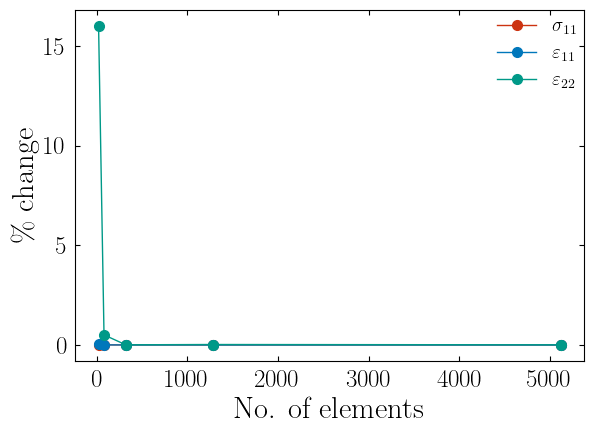

In [23]:
fig, ax = plt.subplots()
ax.plot(df.select('elements'), df.select('S11_pct')*100, label=r'$\sigma_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
# ax.plot(df.select('elements'), df.select('S22_pct')*100, label=r'$\sigma_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.BLUE.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.TEAL.value, marker='o', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'\% change')
ax.legend()
fig.tight_layout()

In [24]:
# Gather data for convergence analysis and compute percent change with increasing element size
df = get_stats_by_angle('_0', JOB_DIRS['linear'].glob('*'))

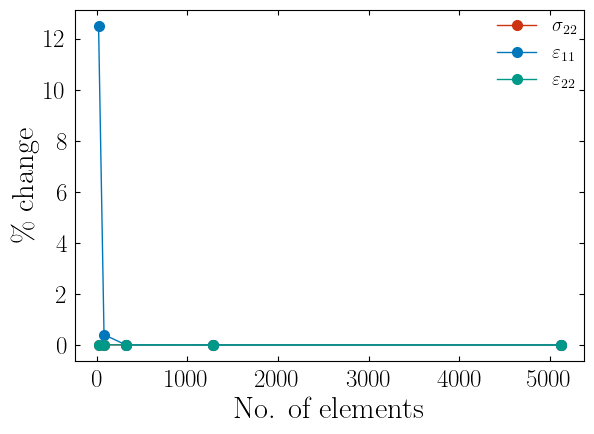

In [25]:
fig, ax = plt.subplots()
ax.plot(df.select('elements'), df.select('S22_pct')*100, label=r'$\sigma_{22}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.BLUE.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.TEAL.value, marker='o', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'\% change')
ax.legend()
fig.tight_layout()

In [26]:
# Gather data for convergence analysis and compute percent change with increasing element size
df = get_stats_by_angle('_45', JOB_DIRS['linear'].glob('*'))

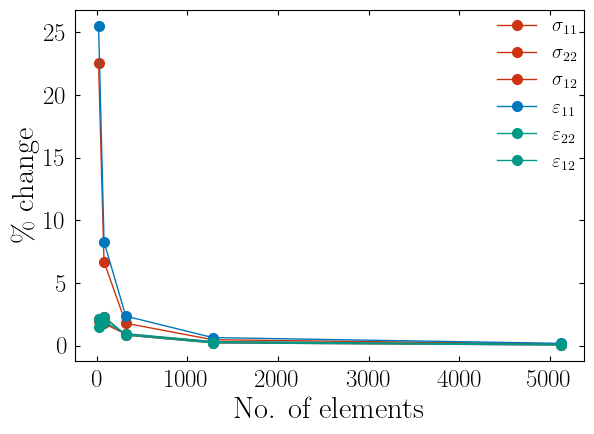

In [27]:
fig, ax = plt.subplots()
ax.plot(df.select('elements'), df.select('S11_pct')*100, label=r'$\sigma_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('S22_pct')*100, label=r'$\sigma_{22}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('S12_pct')*100, label=r'$\sigma_{12}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.BLUE.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.TEAL.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(df.select('elements'), df.select('E12_pct')*100, label=r'$\varepsilon_{12}$', color=pltschemes.VibrantScheme.TEAL.value, marker='o', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'\% change')
ax.legend()
fig.tight_layout()

[[264261.02475062]
 [274789.07477671]
 [279590.95334474]
 [281215.95455252]
 [281696.1284571 ]
 [281834.85663922]]


Text(0, 0.5, 'Elastic modulus [MPa]')

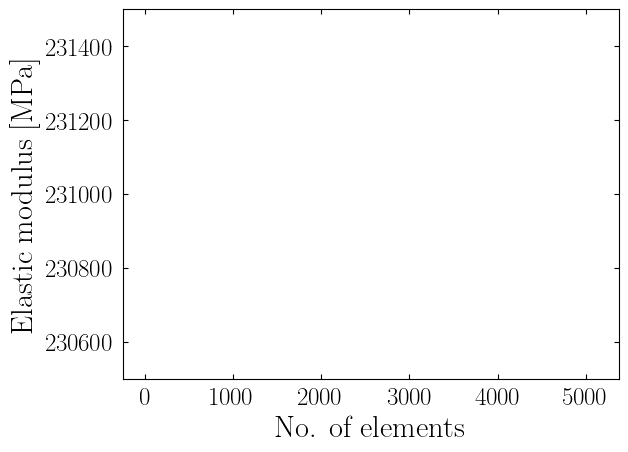

In [28]:
print(df.select(pl.col('S11')/pl.col('E11')).to_numpy())
fig, ax = plt.subplots()
ax.plot(df.select('elements'), df.select(pl.col('S11')/pl.col('E11')).to_numpy(), label='S11 (Linear)', marker='o', linestyle='none')
# # ax.plot(df.select('elements'), df.select('S22')*100, label='S22 (Linear)', marker='o')
# # ax.plot(df.select('elements'), df.select('E11')*100, label='E11 (Linear)', marker='o')
# # ax.plot(df.select('elements'), df.select('E22_pct')*100, label='E22 (Linear)', marker='o')
# ax.legend()
ax.set_ylim([230500, 231500])
ax.set_xlabel('No. of elements')
ax.set_ylabel('Elastic modulus [MPa]')

In [29]:
JOB = 'proj_mesh5_45'
job_dir = pathlib.Path.cwd().joinpath('jobs', 'linear', JOB)
x_assembly = np.load(job_dir.joinpath('assembly_grid.npy'))
Q_assembly = np.load(job_dir.joinpath('assembly_disp.npy'))
F_assembly = np.load(job_dir.joinpath('assembly_reaction_force.npy'))
sig = np.load(job_dir.joinpath('assembly_stress.npy'))
eps = np.load(job_dir.joinpath('assembly_strain.npy'))

In [30]:
# mfe.plot.plot_element_displacement(Q_assembly, x_assembly, method='scatter')

In [31]:
# mfe.plot.plot_element_stress_strain(sig, eps, x_assembly, method='scatter')

In [32]:
JOB_DIRS = {
    'linear': pathlib.Path('./jobs/linear'),
}

theta_data = {}
for fp in JOB_DIRS['linear'].glob('*mesh5*'):
    if not fp.is_dir(): continue
    job_name = fp.stem
    
    # Load simulation data
    # G = np.load(fp.joinpath('gage_.npy'))
    # Q = np.load(fp.joinpath('displacements.npy'))
    # F = np.load(fp.joinpath('reaction_forces.npy'))
    gage_stress = np.load(fp.joinpath('gage_stress_glob.npy'))
    gage_strain = np.load(fp.joinpath('gage_strain_glob.npy'))
    
    # Load summary info
    with open(fp.joinpath('job_summary.log'), 'r') as f:
        summary = {}
        for line in f.readlines():
            k, v = line.split(": ")
            summary.update({k: v.strip()}) 

    # Compute mean props
    theta = int(re.search(r'_(\d+)', job_name).group(1))
    theta_data.update({theta: 
        {
            'elements': summary['Elements'], 
            'nodes': summary['Nodes'],
            'gage_stress': np.mean(gage_stress, axis=(0, 1)),
            'gage_strain': np.mean(gage_strain, axis=(0, 1)),
            # 'disp': np.mean(Q, axis=(0, 1)),
            # 'react': np.mean(F, axis=(0, 1)),
        }
    })

In [64]:
theta = 45
m = np.cos(np.deg2rad(theta))
n = np.sin(np.deg2rad(theta))
sigma_yy = theta_data[theta]['gage_stress'][1][0]
eps_yy = theta_data[theta]['gage_strain'][1][0]
E11 = 231000
E22 = 15000
G12 = 15800

K = np.array([
    [m**2, 2*m*n, (sigma_yy/E11)*m**2],
    [n**2, -2*m*n, (sigma_yy/E11)*n**2],
    [-m*n, (m**2 - n**2), 0],
])
F = np.array([
    [((1/E11)*sigma_yy - eps_yy)*n**2],
    [((1/E22)*sigma_yy - eps_yy)*m**2],
    [((1/G12)*sigma_yy - eps_yy)*m*n],
])
test = np.matmul(np.linalg.inv(K), F)
print(test)
print(theta_data[theta]['gage_strain'])
print(theta_data[theta]['gage_stress'])

[[-9.81672370e-03]
 [-4.87624771e-03]
 [ 8.07458279e+00]]
[[ 8.79034908e-05]
 [ 9.98660297e-03]
 [-8.87786157e-03]]
[[9.36578690e-02]
 [3.12892561e+02]
 [1.20520069e+01]]
